# Fatal police shootings data preparation using `pandas`, `scipy` and `statsmodels`

In this hands-on session you will be introduced to best practices to tackle a time series related project and performing exploratory data analysis. We will be using a modified version of the infamous US [fatal police shootings](https://data.world/data-society/fatal-police-shootings) dataset. Our goal is to prepare this data for the fictional use-case of predicting the number of fatal police shootings.

We will cover the following topics:
1. Data loading, inspection, and transforming to time series dataset
2. Sampling and imputation
3. Stationarity check and performing decomposition
4. Glancing over a possible solution to get started with forecasting, namely ARIMA

Bonus section left as an exercise to the agent
4. Outlier detection

**Instructions**: walk through the notebook while executing all (code) cells. You will encounter 4 exercises, always try to give them a shot. If you get stuck, the answer is given afterwards in a 'SPOILER ALERT' block. Good luck!

---

In [ ]:
# Install requirements
!pip install statsmodels==0.12.1
!pip install plotly==4.14.3

# Import base packages
import pandas as pd 
import numpy as np
import plotly
pd.options.plotting.backend = "plotly"


     |████████████████████████████████| 9.5MB 5.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 13.2MB 339kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


## 1. Dataset loading and inspection

First we will download the fatal police shootings dataset from our bucket. As you can see we have lots of information, including name of the victim, type of violence, whether the killed victim had mental health issues, location, and so on.

In [ ]:
import pandas as pd
from google.colab import auth

# Authenticate
auth.authenticate_user()

# Download
project_id = 'protean-set-301812'
!gcloud config set project {project_id}
bucket_name='structured_data_chapter'
!gsutil cp gs://{bucket_name}/fatal_police_shootings_data_modified.csv /tmp/fatal_police_shootings_data_modified.csv

Updated property [core/project].
Copying gs://structured_data_chapter/fatal_police_shootings_data_modified.csv...
- [1 files][714.6 KiB/714.6 KiB]                                                
Operation completed over 1 objects/714.6 KiB.                                    


In [ ]:
# Read
df = data = pd.read_csv('/tmp/fatal_police_shootings_data_modified.csv')
df.head(2)

,Unnamed: 0,index,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,0,5749,6266,Walter Wallace,2020-10-26,shot,knife,27.0,M,B,Philadelphia,PA,True,other,Not fleeing,True,-75.244,39.958,True
1,1,2144,2393,Earl Riley,2017-02-28,shot,gun,25.0,M,B,Houston,TX,False,attack,Not fleeing,False,-95.538,29.651,True


Our client, the Washington Post, has generated the dataset and wants us to give an estimation on how many **sane** people will be fatally shot by the police in the US over the next weeks. Let's find out which information we can use for that!

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               5772 non-null   int64  
 1   index                    5772 non-null   int64  
 2   id                       5772 non-null   int64  
 3   name                     5569 non-null   object 
 4   date                     5772 non-null   object 
 5   manner_of_death          5772 non-null   object 
 6   armed                    5554 non-null   object 
 7   age                      5524 non-null   float64
 8   gender                   5771 non-null   object 
 9   race                     5245 non-null   object 
 10  city                     5772 non-null   object 
 11  state                    5772 non-null   object 
 12  signs_of_mental_illness  5772 non-null   bool   
 13  threat_level             5772 non-null   object 
 14  flee                    

### Exercise 1: Transform the data to a time series dataset. 
Think about the steps that are needed to solve the use-case. Try transforming the information we have into a time series dataset.

*Hint: Which features should we take into account? What should we do/check before transformation?*

In [ ]:
# Your solution here


**Answer**:

Continue with the notebook (open the spoiler alert)

---



#### SPOILER ALERT

To have this table transformed to a time series dataset, we'll have to aggregate the dataset and select only the columns we need for the filtering, being `date` and `signs_of_mental_illness`.

In [ ]:
df['signs_of_mental_illness'].value_counts()

False    4428
True     1344
Name: signs_of_mental_illness, dtype: int64

In [ ]:
df[["signs_of_mental_illness","date"]].isnull().values.any()

False

**Great!** The features that we need do not have missing data! In this case, we don't need to think about general imputation steps. Let's now visualize how the data is spread across the past few years.

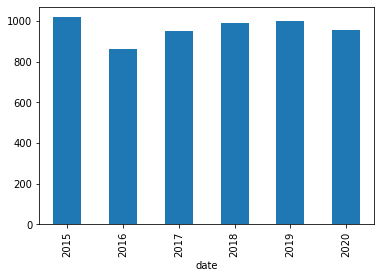

In [ ]:
df["date"] = df["date"].astype("datetime64")
df["date"].groupby(df["date"].dt.year).count().plot(kind="bar")

Let's now aggregate and filter the data in one step. For this, always start working with the lowest level possible, e.g. daily if you have daily data!

---



In [ ]:
tsdf = df[['date', 'signs_of_mental_illness', 'id']].groupby(['signs_of_mental_illness', pd.Grouper(key='date', freq='D')])\
       .count()\
       .reset_index()\
       .rename(columns={'id': 'quantity'})

tsdf = tsdf[tsdf["signs_of_mental_illness"]==False][['date','quantity']].set_index('date')

tsdf.head()

,quantity
date,
2015-01-02,1
2015-01-03,1
2015-01-04,2
2015-01-05,1
2015-01-06,4


See [the pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) for all the options regarding time settings!


---
Nice! now we have a time-series ready dataframe, with one explanatory variable (being the forecast variable itself).
We could add extra columns to this dataframe with variables that can improve predicions (e.g. economic indicators when forecasting sales). In this case we could look for riot data, or include indicators of when controversial legislative decisions were made.


> Small note : When forecasting, keep in mind that some packages (Prophet and NeuralProphet for example) make it possible to add holidays or special events





Before we fit a model to the dataset we need to:
- Impute missing values in our time series dataset, if any
- Gather more insights from the data by decomposing the time series and checking stationarity!


---
## 2. Sampling and imputation

Let's have a look at the data through different glasses, namely sample periods. 

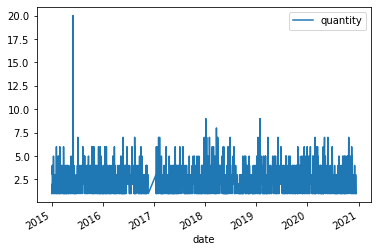

In [ ]:
#daily data
tsdf.plot()

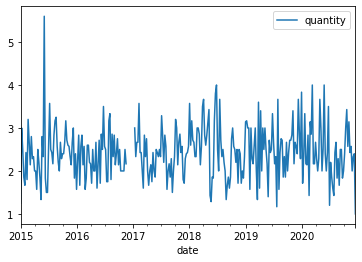

In [ ]:
# weekly
tsdf.resample("W-MON").mean().plot()

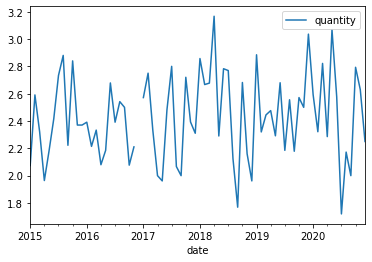

In [ ]:
# monthly 
tsdf.resample("M").mean().plot()

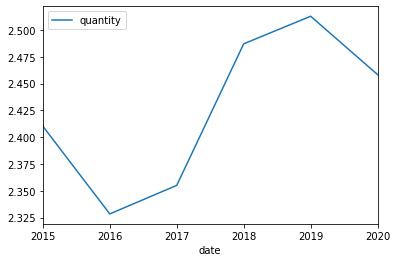

In [ ]:
# yearly
tsdf.resample("Y").mean().plot()

Well well well.. It seems like our customer has **a gap** in its data. Also remark that when we'd only look at the yearly data, we'd not be able to detect that data is missing at all!


*   Because the missing data itself is very concentrated and spans between two different time stamps, it seems **very unlikely that the missingness mechanism is MCAR**.
*   Unfortunately, for this hands-on session I was not able to get the CIO from the Washington Post to join, but he said that in that period, there for sure were fatal police shootings. So we'll have to assume that something simply went wrong in their data collection process and now we have to **patch the gap as good as possible**.


>Note that it does not always make sense to work with the most granular form of the data.
*   Statistical intuition; it is easier to predict what a group of people will do in contrast to what a single person will do. 
*   Keep in mind that the client will probably always want to have the most granular results (e.g. forecasts), so challenge them on this request and keep in mind that aggregating the data can result in a better solution to their problem.


In [ ]:
# Let's resample to weeks to comply with what the client wants in the end!
sampletime = "W-MON"
tsdf = tsdf.resample(sampletime).sum()

# Let's now convert the nans to zeros
tsdf["quantity"] = tsdf["quantity"].replace(0, np.nan)

# Also get rid of the first and last item of the dataset, as we have no data 
# ranging from monday until sunday for those 2 weeks
tsdf = tsdf[1:-1]

### Exercise 2: Impute!

Hint: All of the time series imputation techniques we've covered so far are built-in in pandas. Isn't that nice? See [this link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) for the documentation.

The solution can be found under the spoiler.

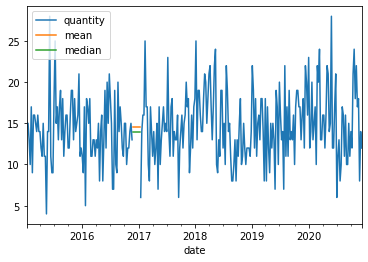

In [ ]:
# To help you out and visualize your results, I prepared this function

def make_data_easy_to_visualize(df):
    """Make sure that the columns that are not called 'quantity' only contain the imputed values.

    Args:
        df (pandas.DataFrame): dataframe containing the original data (in 'quantity' column)
        and imputed data (in the non-'quantity' columns).

    Returns:
        pandas.DataFrame: Cleaned dataframe which shows only the imputed values when plotted.
    """
    index = df['quantity'].index[df['quantity'].apply(np.isnan)]

    int_index_start = df.index.get_loc(index[0])
    int_index_end = df.index.get_loc(index[-1])

    for col in df.columns:
        if col == "quantity":
            continue
        # else
        df[col].iloc[:int_index_start]=None
        df[col].iloc[int_index_end+1:]=None
    return df

# an example with two types of imputation techniques, being mean and median imputation:
testdf = tsdf.copy()
testdf["mean"] = testdf["quantity"].fillna(testdf["quantity"].mean())
testdf["median"] = testdf["quantity"].fillna(testdf["quantity"].median())
dfviztest = make_data_easy_to_visualize(testdf)
dfviztest.plot()

In [ ]:
# Your solution here

---

#### SPOILER ALERT


There are lots of options to choose from, as you can see in the docs. It never hurts to check lots of them, as it's quite straightforward to do. Remember that you can also take a (weighted) combination of multiple imputation techniques!

The ones below are techniques that work very well in practice:

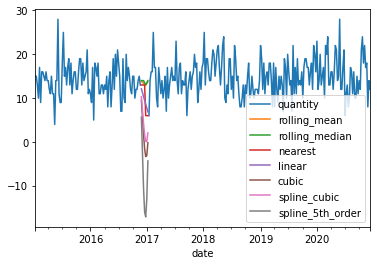

In [ ]:
tsdf["rolling_mean"] = tsdf["quantity"].fillna(tsdf["quantity"].rolling(24,min_periods=1,).mean())
tsdf["rolling_median"] = tsdf["quantity"].fillna(tsdf["quantity"].rolling(24,min_periods=1,).median())

for interpolation_method in ["nearest","linear","cubic"]:
    tsdf[interpolation_method] = tsdf["quantity"].interpolate(method=interpolation_method)

# cubic is the same as a third order polynomial
# df_interpolated["poly"] = df["quantity"].interpolate(method="polynomial", order=3)

tsdf["spline_cubic"] = tsdf["quantity"].interpolate(method="spline", order=3)
tsdf["spline_5th_order"] = tsdf["quantity"].interpolate(method="spline", order=5)

tsdfviz = make_data_easy_to_visualize(tsdf)
tsdfviz.plot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


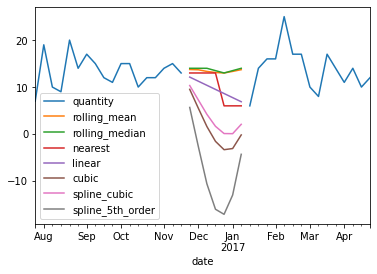

In [ ]:
tsdfviz = make_data_easy_to_visualize(tsdf[80:120])
tsdfviz.plot()

**Lots of options** as you can see. How do you choose whichever suits best? 
1. Tie back to the stakeholders; which interpolation data makes most sense in their experiences?
2. Possibly take a number of options into account for modeling, and check which yields the best results
Extra; If you have enough data from before the gap, you might also be able to wield a forecasting approach to fill in the data

Note that the method that turns out to work best on the weekly data is not necessarily the method that works best on other kinds of aggregations (monthly for example).

In our case, nearest or linear seems to do pretty OK!

In [ ]:
tsdf["quantity"] = tsdf["quantity"].fillna(tsdf["quantity"].rolling(24,min_periods=1,).median())

## 3. Check stationarity and perform time series decomposition

Let's have a look at the decomposition using our beloved [STL method](https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html). For the stationarity check, we'll use the combination of [KPSS](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html) and [ADF](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html?highlight=adf#statsmodels.tsa.stattools.adfuller). Be sure to double check the null hypotheses for each, because they have a different meaning!

---
### Exercise 3: Interpret results of STL and the stationarity checks



In [ ]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller as adf

# Your solution here

#### SPOILER ALERT

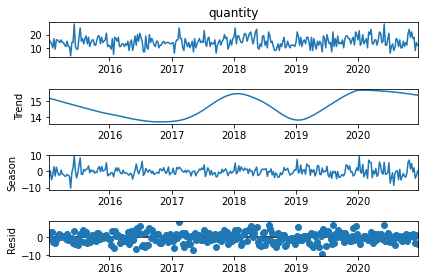

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(tsdf["quantity"])
res = stl.fit()
fig = res.plot()

There's no seasonality we can infer from the data, and the trend (small changes really, but still indicative) shows that there might be some underlying process going on that shows why these fluctuations exist over time. 

After some research, it seems that a very plausible explanation lies within the fact that these fluctuations are the result of **multiple processes going on at once**. 


> It appears that police violence over the past years has increased in rural regions, while fatal police shootings happened less in big cities because of regulations and awareness [[Source](https://fivethirtyeight.com/features/police-are-killing-fewer-people-in-big-cities-but-more-in-suburban-and-rural-america/)]. That also means that at this point, we should pivot and split the data to have a data set representing rural regions and urban regions. I'll leave this as homework and we'll continue as-is ;)



In [ ]:
kpsstest = kpss(tsdf["quantity"])
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value

adftest = adf(tsdf["quantity"], autolag='AIC')
adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adftest[4].items():
    adf_output['Critical Value (%s)'%key] = value

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [ ]:
print("KPSS\n",kpss_output,"\n")
print("ADF\n",adf_output,"\n")

KPSS
 Test Statistic            0.221697
p-value                   0.100000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 

ADF
 Test Statistic                -1.574859e+01
p-value                        1.231134e-28
#Lags Used                     0.000000e+00
Number of Observations Used    3.090000e+02
Critical Value (1%)           -3.451691e+00
Critical Value (5%)           -2.870939e+00
Critical Value (10%)          -2.571778e+00
dtype: float64 



If we arbitrarily pick 0.05 as alpha (the critical value/significance level), then:
1. **The null hypothesis** can not be rejected for the **KPSS test** (null hypothesis = no unit root = data is stationary; rejecting null hypothesis = unit root = data is not stationary)
2. There is evidence for **rejecting the null hypothesis** in favor of the alternative for the **ADF test**. (null hypothesis = unit root = data is not stationary; rejecting null hypothesis = no unit root = data is stationary)

This means that both test say that the data is stationary already, Yay!

---

In case these tests say that the data is not stationary, transformations such as differencing can change this (see below for an example)

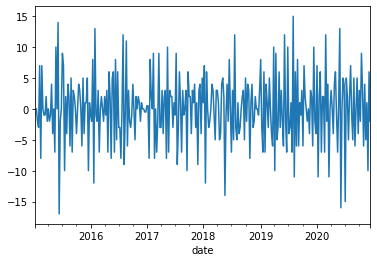

In [ ]:
diff = tsdf['quantity'] - tsdf['quantity'].shift(1)
df = diff.notna()
diff.plot()

## 4. Ready to do forecasting!

This section shows how we can then train a first benchmarking model, namely ARIMA to end conclude this hands-on!

In [ ]:
!pip install pyramid-arima

In [ ]:
train = tsdf["quantity"][:290]
test = tsdf["quantity"][290:]

In [ ]:
print(train.shape)
print(test.shape)

(290,)
(20,)


In [ ]:
import pyramid as pm

# Fit two different ARIMAs
m = pm.auto_arima(train, error_action='ignore', seasonal=False, suppress_warnings=True)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision 

In [ ]:
#check the order of the final arima model: 
print(m.order)

(1, 0, 1)


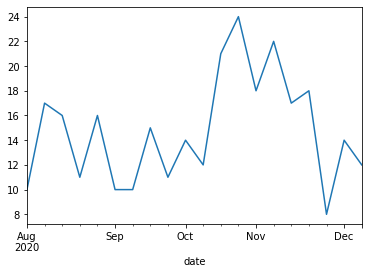

In [ ]:
test.plot()

Text(0.5, 1.0, 'Test samples vs. forecasts')

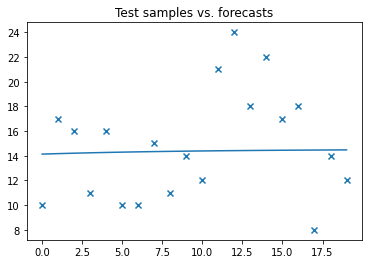

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
x = np.arange(test.shape[0])

# Plot
axes.scatter(x, test, marker='x')
axes.plot(x, m.predict(n_periods=test.shape[0]))
axes.set_title('Test samples vs. forecasts')

It seems like our best performing ARIMA model is not able to model the fluctuations, which is no big surprise as the data itself is very arid and does not show a constant seasonal component. Do not be demotivated at this point, because these results (forecasting a near straight line with your best model) is happening lots of times when working with time series. The best things you can do at this point are : 
1. Tie back and check assumptions (data imputation/sampling)
2. Tie back and rephrase the use-case question (rural vs urban)
3. Add in extra data such as indicators
4. Try out some more models (other configurations of ARIMA, theta, Prophet, NeuralProphet (? - WIP))
5. Check for outliers --> see extra section

# In summary

You have been introduced to the go to way of tackling a time series project in which we learnt how to turn your tabular dataset into a time series dataset, resample the dataset and run an exploratory analysis. You saw how you, as a time series expert, check for stationarity and decompose time series data to gain insights from the data at hand. You also saw some specific time series imputation techniques.

---

## Bonus Content


### 5. Outlier detection

One thing we didn't cover and you might need in your projects is outlier detection!

For this purpose, we prepared a out of the box function in which you can use on out of 3 different SOTA outlier detection techniques. Can you find the two most apparent outliers in the dataset?

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

def outlier_detection(series, method, **kwargs):
    """
    series is preferably the residual series
    method is one of: 'regression', 'forest', SVM'
        (linear regression, IsolatedForest, OneClassSVM)
        default to SVM
        (default parameters: k=3, outliers_fraction = 0.01 (for contamination and nu),  gamma = 0.01)

    returns the indices of the outliers
    """

    if method == 'regression':

        # set k parameter. How many std from many to be outlier
        if "k" in kwargs:
            k = kwargs["k"]
        else:
            k = 3

        # fit linear model
        X = [i for i in range(0, len(series))]
        X = np.reshape(X, (len(X), 1))
        y = series.values
        model = LinearRegression()
        model.fit(X, y)
        # calculate trend
        trend = model.predict(X)
        # detrend
        detrended = [y[i] - trend[i] for i in range(0, len(series))]
        # determine mean and std
        mean = np.mean(detrended)
        std = np.std(detrended)
        # location of outliers. If more than k times from mean
        idx = (detrended < mean - k * std) | (detrended > mean + k * std)
        idx = [counter for counter, value in enumerate(idx) if value]

    elif method == "forest":

        # set outliers_fraction parameter. proportion of outliers in the data set
        if "outliers_fraction" in kwargs:
            outliers_fraction = kwargs["outliers_fraction"]
        else:
            outliers_fraction = 0.01

        series = pd.DataFrame(series)
        # fit Isolated forest
        scaler = StandardScaler()
        np_scaled = scaler.fit_transform(series)
        series = pd.DataFrame(np_scaled)
        model = IsolationForest(contamination=outliers_fraction)
        model.fit(series)
        # predict data
        anomaly = pd.Series(model.predict(series))
        # location of outliers
        idx = [counter for counter, value in enumerate(anomaly) if value == -1]
        
    else:  # OneClassSVM

        # set outliers_fraction parameter. Basically proportion of outliers in the data set
        if "outliers_fraction" in kwargs:
            outliers_fraction = kwargs["outliers_fraction"]
        else:
            outliers_fraction = 0.01
        # smoothing paramter
        if "gamma" in kwargs:
            gamma = kwargs["gamma"]
        else:
            gamma = 0.01

        series = pd.DataFrame(series)
        # fit SVM
        scaler = StandardScaler()
        np_scaled = scaler.fit_transform(series)
        series = pd.DataFrame(np_scaled)
        model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
        model.fit(series)
        # predict data
        anomaly = pd.Series(model.predict(series))
        # location of outliers
        idx = [counter for counter, value in enumerate(anomaly) if value == -1]

    return idx

In [ ]:
# Ideally, you end up with a very clean decomposition of trend, seasonality component and residuals
# in that case, do outlier detection on the residuals (res is the returned object from the STL decomposition)
outlier_detection(res.resid, method="regression")
# we'll get results from this, 
# but because the decomposition visually hasn't been all that nice, we better rely on the original dataset

[109, 229]

In [ ]:
# when this is not the case (in this example), you should put more emphasis on the outlier detection of the original time series
outlier_detection(tsdf["quantity"], method="regression")

[21, 281]

In [ ]:
# 21: because data was duplicated! (you can check this in original dataset) - see below
# 281: to check with client, outlier or not?

In [ ]:
tsdf.iloc[21].name

Timestamp('2015-06-08 00:00:00', freq='W-MON')

In [ ]:
data["date"] = data["date"].astype("datetime64")
data[(data["date"] > pd.Timestamp(2015, 6, 2)) & (data["date"] < pd.Timestamp(2015, 6, 4))]
# Roald Neal snuck in the dataset too many times!

,Unnamed: 0,index,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
83,86,405,511,Roald Neal,2015-06-03,shot,NaN,66.0,M,W,Byram,TN,False,attack,Car,False,-71.470367,42.169619,False
115,118,405,511,Roald Neal,2015-06-03,shot,NaN,66.0,M,W,Byram,TN,False,attack,Car,False,-73.808145,41.255998,False
490,500,405,511,Roald Neal,2015-06-03,shot,NaN,66.0,M,W,Byram,TN,False,attack,Car,False,-71.319179,43.713788,False
671,686,405,511,Ronald Neal,2015-06-03,shot,gun,56.0,M,W,Byram,NJ,True,attack,Not fleeing,False,-73.808145,41.255998,True
842,859,405,511,Roald Neal,2015-06-03,shot,gun,66.0,M,W,Byram,TN,True,attack,Car,False,-73.808145,41.255998,True
938,957,404,510,Edelmiro Hernandez,2015-06-03,shot,knife,33.0,M,H,Fuqua,TX,False,other,Car,False,-95.214000,29.619000,True
1033,1053,405,511,Ronald Neal,2015-06-03,shot,gun,66.0,M,W,Byram,NJ,True,attack,Not fleeing,False,-73.808145,41.255998,True
1090,1110,405,511,Roald Neal,2015-06-03,shot,NaN,66.0,M,W,Byram,TN,False,attack,Car,False,-69.867989,44.920908,False
1384,1411,405,511,Roald Neal,2015-06-03,shot,NaN,66.0,M,W,Byram,TN,False,attack,Car,False,-71.470367,43.074678,False
1430,1459,405,511,Roald Neal,2015-06-03,shot,NaN,66.0,M,W,Byram,TN,False,attack,Car,False,-73.772326,41.255998,False
